In [1]:
#Libraries
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

#Configuration for the font and style in the graphics
params = {
        'font.family': 'serif',
        'font.serif': ['STIXGeneral', 'Times New Roman'],
        'font.size': 14,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'legend.fontsize': 14,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'mathtext.fontset': 'stix',
        'text.usetex': False,
        'figure.figsize': (6.4, 4.8),
        'savefig.format': 'pdf',
        'savefig.bbox': 'tight'
    }
    
plt.rcParams.update(params)

In [2]:
VIS_data = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Visible range\Data\Values_VIS.xlsx")
NIR_data = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Infrared range\Data\Values_NIR.xlsx")
SPA_data = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Spatially Resolved Atlas\Data\Values_SPA.xlsx")
ALL_data = pd.concat([VIS_data,NIR_data],axis=0).drop_duplicates('Observed wavelength',keep='first').reset_index(drop=True) #Dont take repeated values when concatenate
 

## Gray and Oostra standard curve

### Give a third order polynomial fit for each color

The range used on Gray and Oostra article for the standard curve was 6020–6340 Å, we can stablish just a green range (4970-5700 Å) for comparised and report all the color curves started on violet range.

For consistency, the standard curve is comparised only using the visible range for the solar flux atlas.

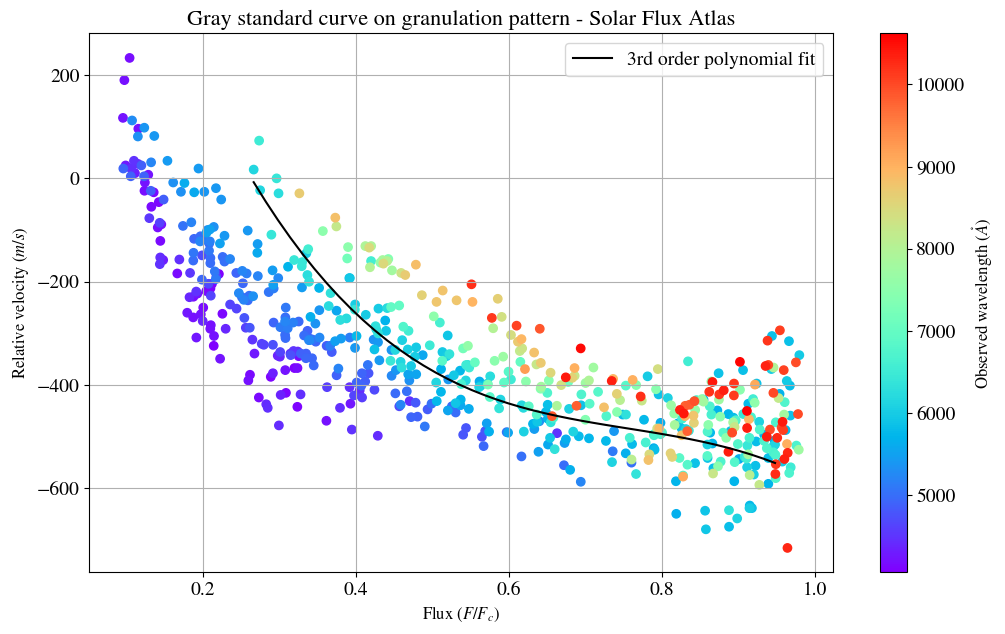

In [3]:
#Take the range from Gray and Oostra
values_VIS_standard = VIS_data[VIS_data['Observed wavelength'].between(6020,6340, inclusive='right')]

fig1, ax = plt.subplots(1,1,figsize=(12,7))

ax.set_title(r'Gray standard curve on granulation pattern - Solar Flux Atlas')

pol = Polynomial.fit(values_VIS_standard['Flux'],values_VIS_standard['Velocity'], 3)
param = pol.convert().coef
values_flux = np.linspace(min(values_VIS_standard['Flux']), max(values_VIS_standard['Flux']), len(values_VIS_standard['Flux']))
flux_fit = poly.polyval(values_flux,param)

scatter = ax.scatter(VIS_data['Flux'],VIS_data['Velocity'],c=VIS_data["Observed wavelength"],cmap='rainbow',lw=1,marker='o')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.plot(values_flux,flux_fit,color='k',label='3rd order polynomial fit')

ax.set_xlabel(r'Flux $(F/F_{c})$',fontsize=12)
ax.set_ylabel(r'Relative velocity $(m/s)$',fontsize=12)
ax.legend()
ax.grid()

# fig1.savefig('Standard curve_Gray.pdf')

The report is only for the specific range and shifted the curved +633 m/s

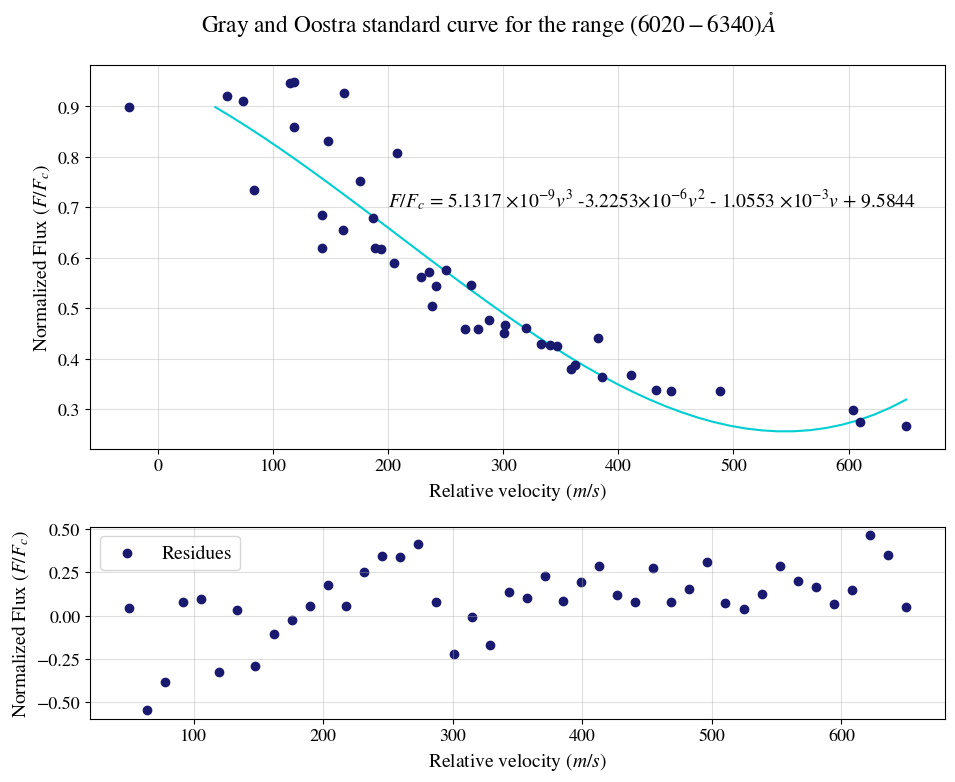

In [ ]:
#In the report is given in function of the velocity

pol = Polynomial.fit(values_VIS_standard['Velocity']+633,values_VIS_standard['Flux'], 3)
param = pol.convert().coef
values_vel = np.linspace(50, max(values_VIS_standard['Velocity']+633), len(values_VIS_standard))
vel_fit = pol(values_vel)

#Calculate the residues
residuos = (values_VIS_standard['Flux']) - vel_fit
std_flux = np.std(residuos) 

#Plot for fixed the zero point of velocity
fig2, axis = plt.subplots(2,1, figsize = (10, 8), gridspec_kw = {"height_ratios":[2, 1]})
ax1 = axis[0]
ax2 = axis[1]

fig2.suptitle(r'Gray and Oostra standard curve for the range $(6020-6340)\mathring{A}$')

ax1.errorbar(values_VIS_standard['Velocity']+633,values_VIS_standard['Flux'], capsize=6,fmt='o', color='midnightblue')
ax1.plot(values_vel,vel_fit,c='darkturquoise')
ax1.text(200,0.7,fr'$F/F_c$ = {round(param[3]*1e9,4)} $\times 10^{{-9}}v^3$ -{round(param[2]*-1e6,4)}$\times 10^{{-6}}v^2$ - {round(param[1]*-1e3,4)} $\times 10^{{-3}}v$ + {round(param[0]*10,4)}',c='k')
ax1.set_ylabel(r'Normalized Flux $(F/F_{c})$')
ax1.set_xlabel(r'Relative velocity $(m/s)$')
ax1.grid(alpha=0.4)
ax1.tick_params(axis='both',labelsize=13)

ax2.scatter(values_vel,residuos,c='midnightblue',label='Residues')
ax2.set_xlabel(r'Relative velocity $(m/s)$')
ax2.set_ylabel(r'Normalized Flux $(F/F_{c})$')
ax2.grid(alpha=0.4)
ax2.legend()
ax2.tick_params(axis='both',labelsize=13)


fig2.tight_layout()

# fig2.savefig('Standard curve gray')

In [146]:
param

array([ 9.58438970e-01, -1.05528079e-03, -3.22527864e-06,  5.13169816e-09])

### Standard curves for visible range

In [13]:
#Separate for range in colors for color fits

values_ALL = [ ALL_data[ALL_data['Observed wavelength'].between(3800, 4270, inclusive='right') ], #Purple
                ALL_data[ALL_data['Observed wavelength'].between(4270, 4760, inclusive='right')], #Blue
                ALL_data[ALL_data['Observed wavelength'].between(4760, 4970, inclusive='right')], #Cyan
                ALL_data[ALL_data['Observed wavelength'].between(4970, 5700, inclusive='right')], #Green 
                ALL_data[ALL_data['Observed wavelength'].between(5700, 5810, inclusive='right')], #Yellow
                ALL_data[ALL_data['Observed wavelength'].between(5810, 6180, inclusive='right')], #Orange
                ALL_data[ALL_data['Observed wavelength'].between(6180, 7000, inclusive='right')]] #Red

#colors for the plot
colors_fit = ['Violet','Blue','Cyan','Green','Yellow','Orange','Red']
colors = ['darkviolet','darkblue','darkcyan','darkgreen','gold','darkorange','darkred']
colors_wave = [4000,4500,4850,5500,5800,6000,7000]

#List for the data
param_ALL = []
fit_ALL = []

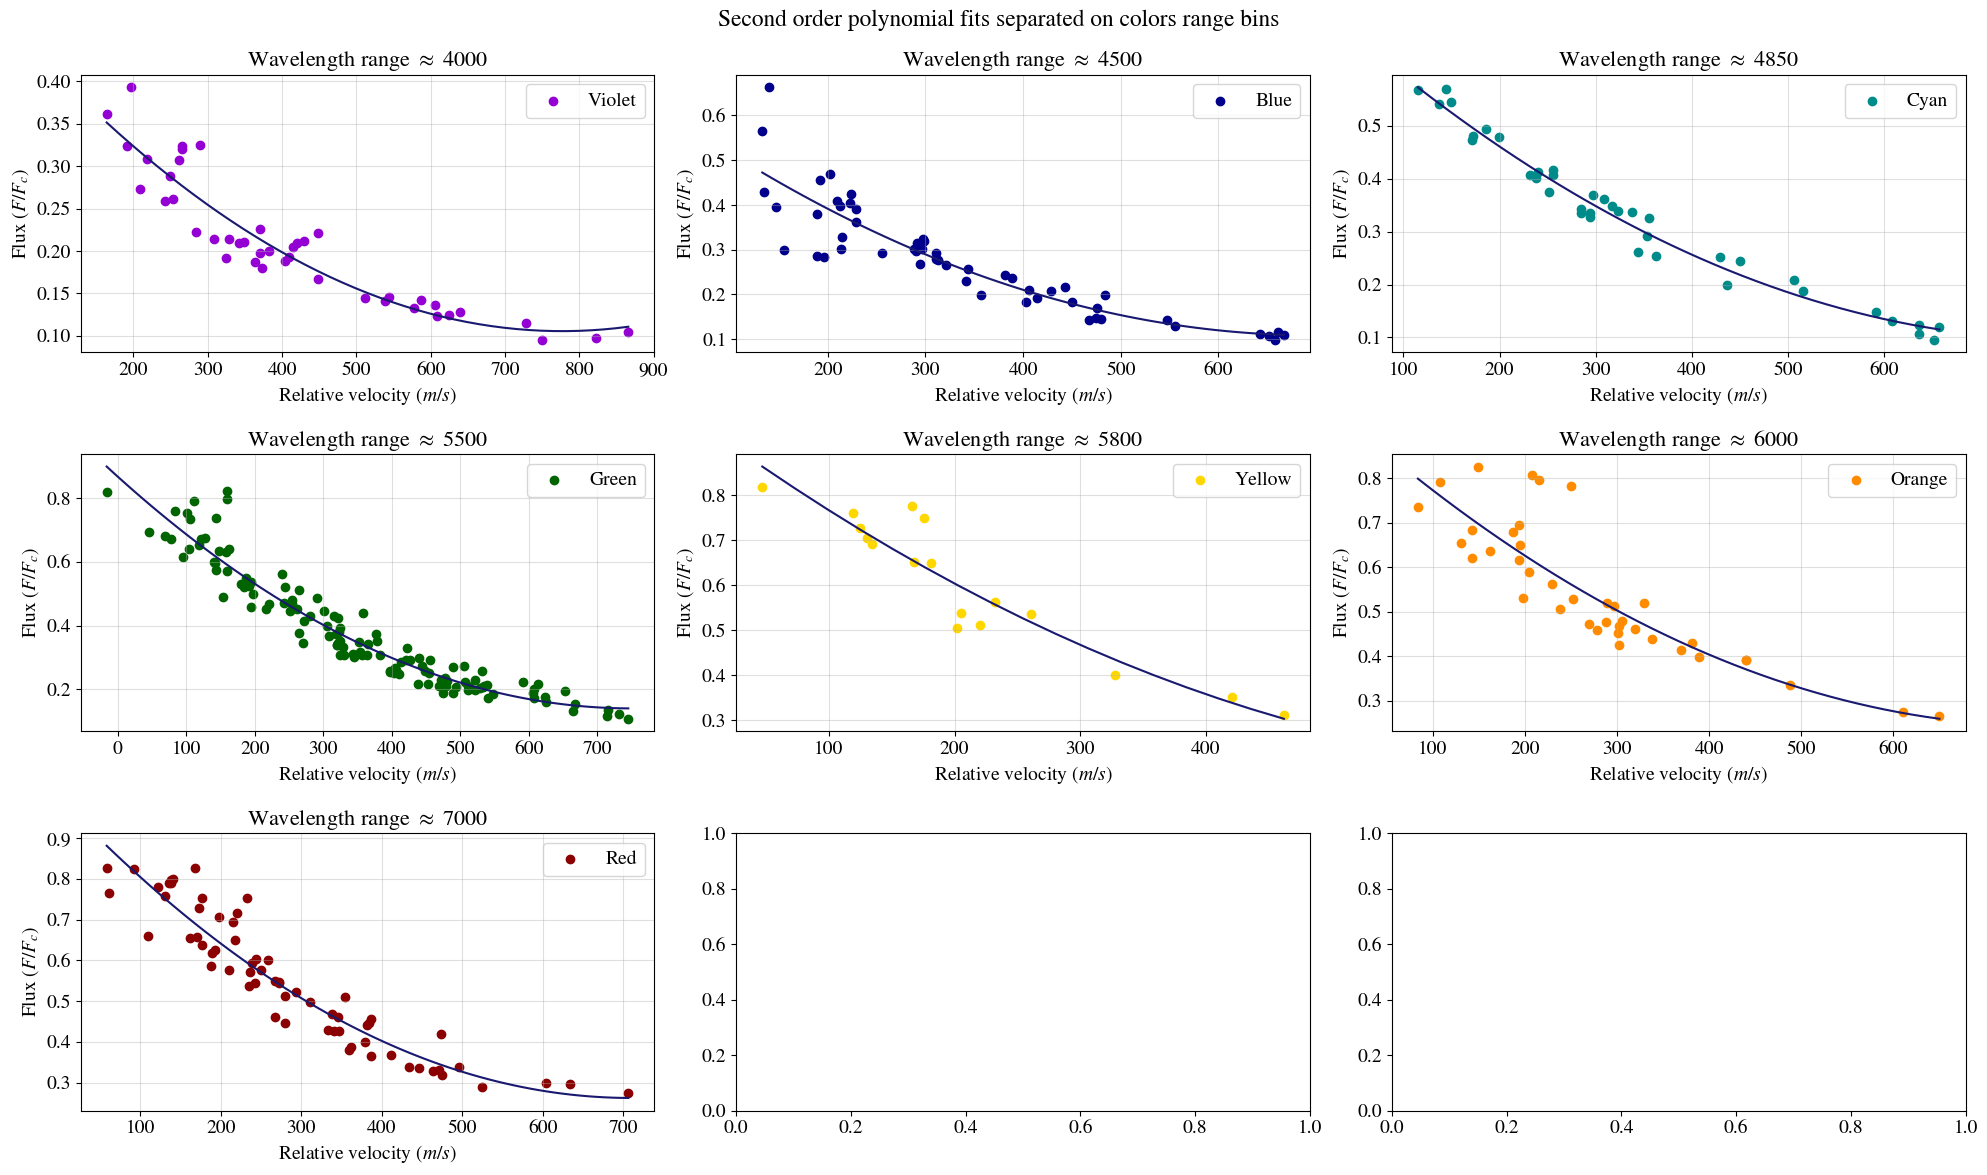

In [14]:
fig5, axes = plt.subplots(3,3,figsize=(20,12))
fig5.suptitle('Second order polynomial fits separated on colors range bins')
axes = axes.flatten()

#Plot the cuadratic fit for each color
for i, ax in enumerate(axes):
        if i < len(values_ALL):
                data = values_ALL[i][values_ALL[i]['Flux'].between(0,0.83)]
        
                ax.scatter(data['Velocity']+633,data['Flux'],c=colors[i],label='{}'.format(colors_fit[i]))
                ax.set_title(r'Wavelength range $\approx$ {}'.format(colors_wave[i]))
                ax.grid(alpha=0.4)

                pol = Polynomial.fit(data['Velocity']+633,data['Flux'], 2)
                param = pol.convert().coef
                values_flux = np.linspace(min(data['Velocity']+633), max(data['Velocity']+633), len(data))
                flux_fit = poly.polyval(values_flux,param)
                param_ALL.append(pd.DataFrame(param[-1::-1]))
                fit_ALL.append([values_flux,flux_fit])

                ax.plot(values_flux,flux_fit, color='midnightblue')

                ax.legend()
                ax.set_ylabel(r'Flux $(F/F_{c})$')
                ax.set_xlabel(r'Relative velocity $(m/s)$')

fig5.tight_layout()
# fig5.savefig('color curves')

In [15]:
#Calculate te average and show the parameters
parameters_ALL = pd.concat(param_ALL,axis=1)
parameters_ALL = parameters_ALL.set_axis(colors_wave, axis=1)
parameters_ALL = parameters_ALL.T.set_axis(['2nd order','1st order','Shift'],axis=1)
parameters_ALL['Colors'] = colors_fit

parameters_ALL 

,2nd order,1st order,Shift,Colors
4000,6.543126e-07,-0.001017,0.500595,Violet
4500,1.132448e-06,-0.001585,0.663215,Blue
4850,1.030765e-06,-0.001639,0.747327,Cyan
5500,1.292572e-06,-0.001939,0.867182,Green
5800,1.331460e-06,-0.002029,0.955896,Yellow
6000,1.190184e-06,-0.001826,0.943474,Orange
7000,1.456927e-06,-0.002068,0.996047,Red


Take as reference the green curve and scaling all the others, we see that all the coeficients that multiplied the green curve have the same values, making one coeficient general to scale the curve

In [16]:
# The reference point is the green part, the color coefficient is waht are in the table
scale_coeff = pd.DataFrame()
scale_coeff['2nd order'] = parameters_ALL['2nd order']/parameters_ALL['2nd order'].iloc[3]
scale_coeff['1st order'] = parameters_ALL['1st order']/parameters_ALL['1st order'].iloc[3]
scale_coeff['Shift'] = parameters_ALL['Shift']/parameters_ALL['Shift'].iloc[3]
scale_coeff['Colors'] = colors_fit
scale_coeff['Mean coeff'] = np.mean(np.array([scale_coeff['2nd order'],scale_coeff['1st order'],scale_coeff['Shift']]),axis=0)

scale_coeff

,2nd order,1st order,Shift,Colors,Mean coeff
4000,0.506210,0.524425,0.577266,Violet,0.535967
4500,0.876120,0.817607,0.764793,Blue,0.819507
4850,0.797453,0.845348,0.861788,Cyan,0.834863
5500,1.000000,1.000000,1.000000,Green,1.000000
5800,1.030086,1.046239,1.102302,Yellow,1.059542
6000,0.920788,0.941605,1.087977,Orange,0.983457
7000,1.127154,1.066661,1.148602,Red,1.114139


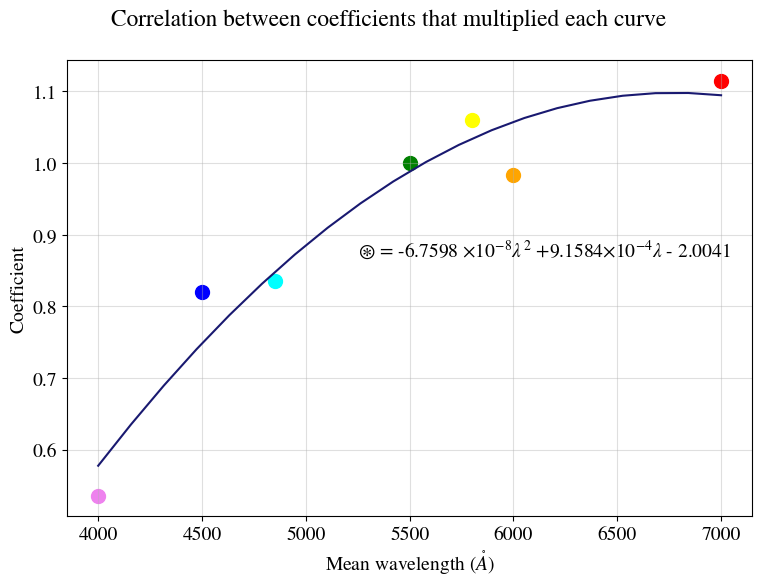

In [ ]:
fig3, ax = plt.subplots(1,1,figsize=(8,6))

for i in colors_wave:
    ax.scatter(i,scale_coeff['Mean coeff'][i],marker='o',c=scale_coeff['Colors'][i],s=100)

pol = Polynomial.fit(colors_wave,scale_coeff['Mean coeff'], 2)
param = pol.convert().coef
values_flux = np.linspace(min(colors_wave), max(colors_wave), 20)
flux_fit = poly.polyval(values_flux,param)

ax.plot(values_flux,flux_fit,c='midnightblue')
ax.text(5250,0.87,fr'$\circledast$ = {round(param[2]*1e8,4)} $\times 10^{{-8}}\lambda^2$ +{round(param[1]*1e4,4)}$\times 10^{{-4}}\lambda$ - {round(param[0]*-1,4)}',c='k')
fig3.suptitle('Correlation between coefficients that multiplied each curve')

ax.set_xlabel(r'Mean wavelength ($\mathring{A}$)')
ax.set_ylabel(r'Coefficient')
ax.grid(alpha = 0.4)

fig3.tight_layout()
# fig3.savefig('color coeficients')

In [18]:
param

array([-2.00407731e+00,  9.15837527e-04, -6.75984770e-08])

### Standard curves for near infrared range

In [22]:
values_NIR = [ ALL_data[ALL_data['Observed wavelength'].between(7000, 8500, inclusive='right') ],
                ALL_data[ALL_data['Observed wavelength'].between(8500, 11000, inclusive='right')], 
                ALL_data[ALL_data['Observed wavelength'].between(11000, 16000, inclusive='right')], 
                ALL_data[ALL_data['Observed wavelength'].between(16000, 19000, inclusive='right')]]

#colors for the plot
colors_nir = ['brown','chocolate','indianred','darksalmon']

#List for the data
param_NIR = []
fit_NIR = []
colors_wave_nir = [7000,10000,14000,18000]

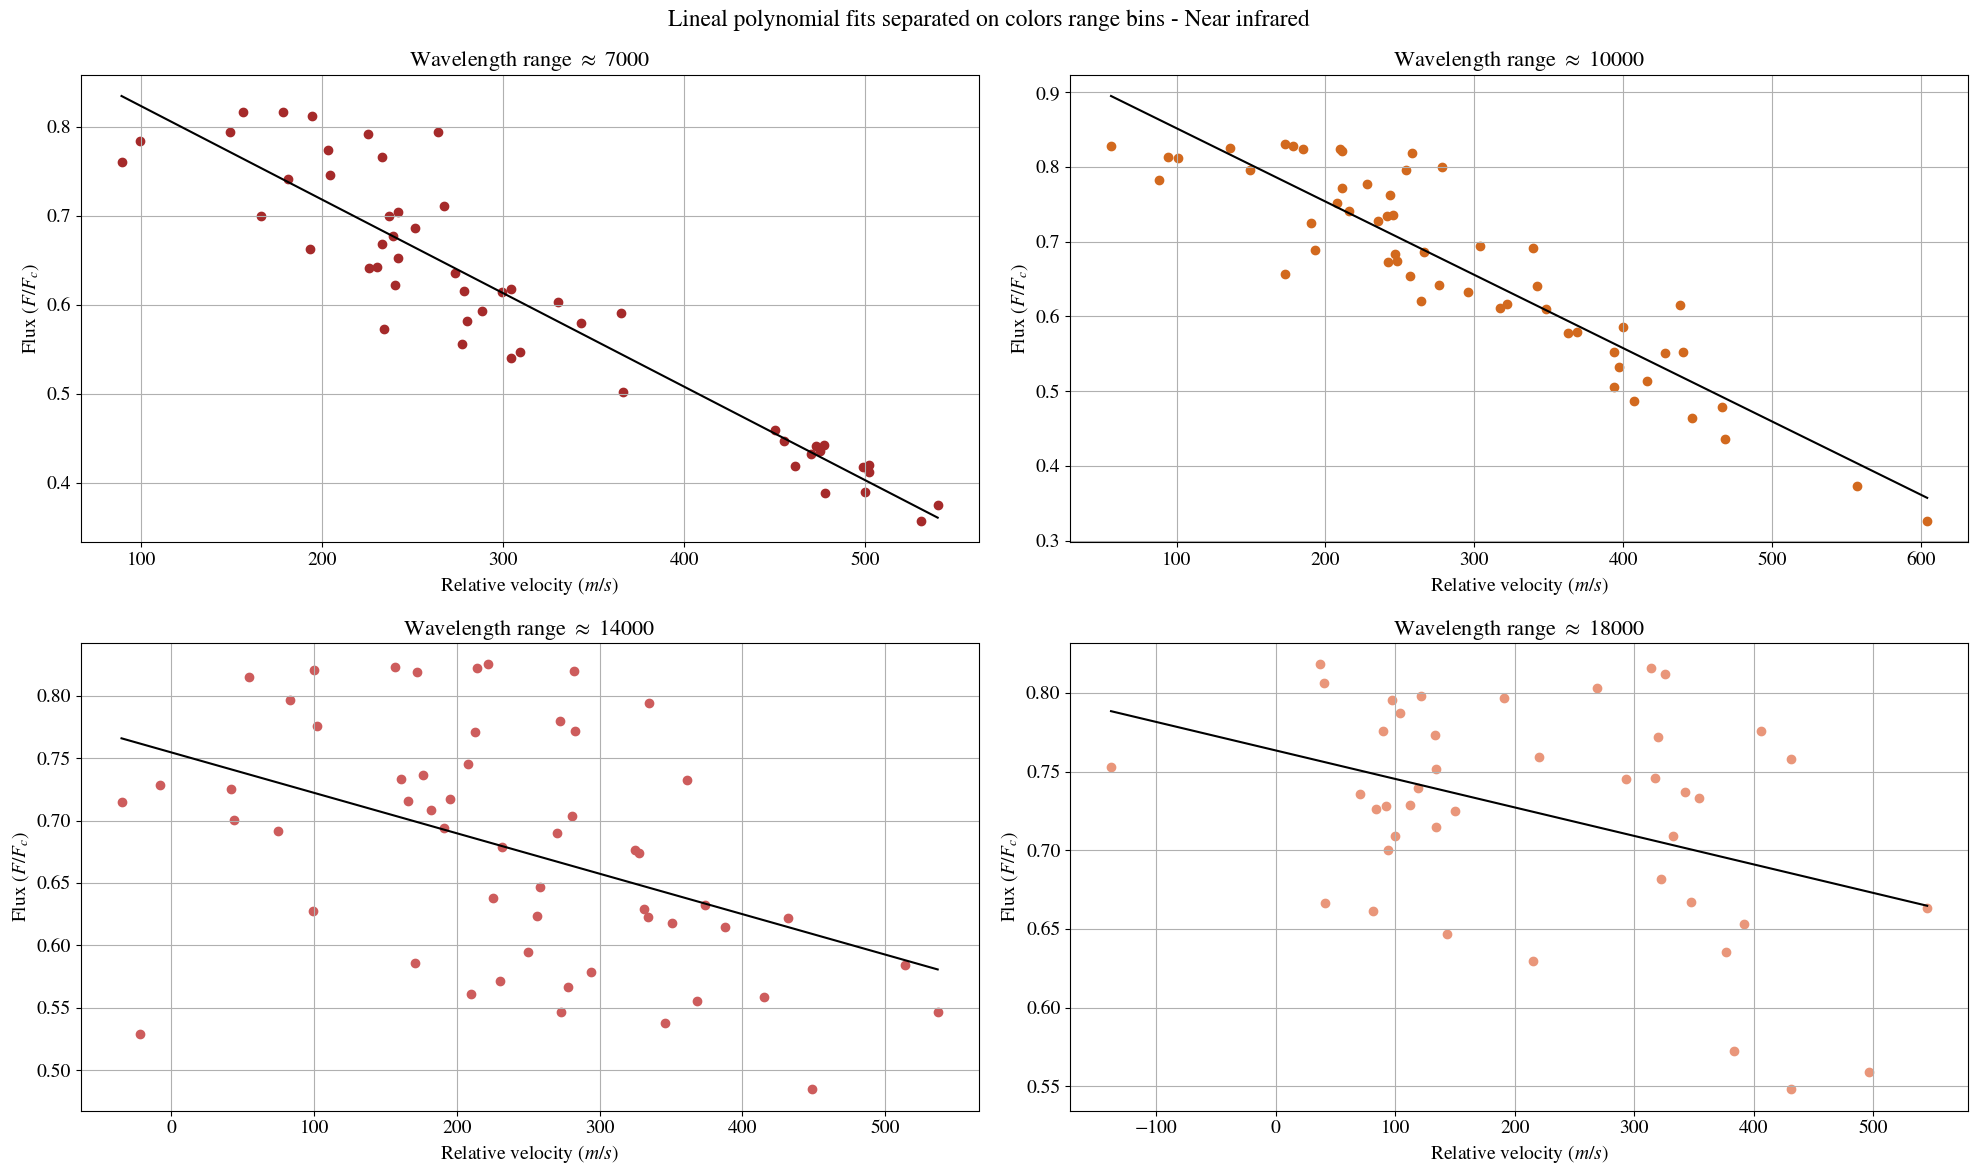

In [ ]:
fig5, axes = plt.subplots(2,2,figsize=(20,12))
fig5.suptitle('Lineal polynomial fits separated on colors range bins - Near infrared')
axes = axes.flatten()

#Plot the cuadratic fit for each color
for i, ax in enumerate(axes):
        if i < len(values_NIR):
                data = values_NIR[i][values_NIR[i]['Flux'].between(0,0.83)]
        
                ax.scatter(data['Velocity']+633,data['Flux'],c=colors_nir[i])
                ax.set_title(r'Wavelength range $\approx$ {}'.format(colors_wave_nir[i]))
                ax.grid()

                pol = Polynomial.fit(data['Velocity']+633,data['Flux'], 1)
                param = pol.convert().coef
                values_flux = np.linspace(min(data['Velocity']+633), max(data['Velocity']+633), len(data))
                flux_fit = poly.polyval(values_flux,param)

                #add to dataframes
                param_NIR.append(pd.DataFrame(param[-1::-1]))
                fit_NIR.append([values_flux,flux_fit])

                ax.plot(values_flux,flux_fit, color='k')

                ax.set_ylabel(r'Flux $(F/F_{c})$')
                ax.set_xlabel(r'Relative velocity $(m/s)$')

fig5.tight_layout()

# fig5.savefig('color curves nir')

In [260]:
#Calculate te average and show the parameters
parameters_NIR = pd.concat(param_NIR,axis=1)
parameters_NIR = parameters_NIR.set_axis(colors_wave_nir, axis=1)
parameters_NIR = parameters_NIR.T.set_axis(['Slope','Shift'],axis=1)

parameters_NIR 

,Slope,Shift
7000,-0.001051,0.927993
10000,-0.000981,0.949625
14000,-0.000324,0.754614
18000,-0.000181,0.763366
